In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn
import splinelib as tsp

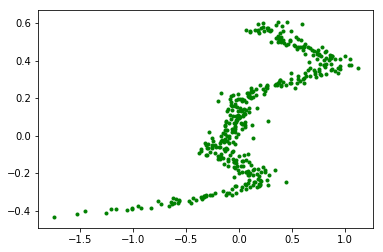

In [2]:
x = np.linspace(0,1,400)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(y, x, marker='.', color='g')

## Inverse Function (y-->x) optimization

In [3]:
def _calculate_rangeY_(self:tsp.Spline1D, y):
    rangeY = np.zeros((self.n_points-1, y.shape[0]))
    def _inrange2_(X, break0, break1): #if x is after
        xmsk1 = X >= break0
        xmsk2 = X < break1
        xmsk12 = np.bitwise_and(xmsk1, xmsk2)
        xmsk3 = X < break0
        xmsk4 = X >= break1
        xmsk34 = np.bitwise_and(xmsk3, xmsk4)
        xs = np.bitwise_or(xmsk12, xmsk34)
        return xs

    for i in range(self.n_points-1):
        if self.n_points-2 == 0:
            rangeY[i] = _inrange2_(y, -np.inf, np.inf)
        elif i==0:
            sign = -1 if self.Y[0]<self.Y[1] else 1
            rangeY[i] = _inrange2_(y, sign*np.inf, self.Y[1])
        elif i== self.n_points-2:
            sign = 1 if self.Y[i]<self.Y[i+1] else -1
            rangeY[i] = _inrange2_(y, self.Y[i], sign*np.inf)
        else:
            rangeY[i] = _inrange2_(y, self.Y[i], self.Y[i+1])
    return rangeY

def reverse1(self:tsp.Spline1D, y, rangeY=None):
    if rangeY is None:
        rangeY = _calculate_rangeY_(self, y)
        
    x = np.zeros_like(self.rangeX)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x[i] = xpossible*rangeY[i]
    return x

_______________________
Steps 0
Error 0.942413747108085


_______________________
Steps 100
Error 0.11738512359720304


_______________________
Steps 200
Error 0.08982828545416434


_______________________
Steps 300
Error 0.07581164926839284


_______________________
Steps 400
Error 0.04554262324943464


_______________________
Steps 500
Error 0.030914216513746977


_______________________
Steps 600
Error 0.022603133512303537


_______________________
Steps 700
Error 0.019373559649402898


_______________________
Steps 800
Error 0.017976107277741522


_______________________
Steps 900
Error 0.017357676355615127


_______________________
Steps 1000
Error 0.016975948813203343


_______________________
Steps 1100
Error 0.016691893705591827


_______________________
Steps 1200
Error 0.016477552621959757


_______________________
Steps 1300
Error 0.01630868200604924


_______________________
Steps 1400
Error 0.016163649856922674


_______________________
Steps 1500
Error 0.01603906130250486

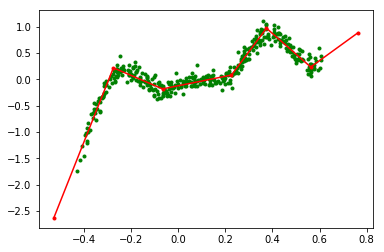

In [7]:
%matplotlib tk

max_points = 7
lr=0.1
spline = tsp.Spline1D(max_points, x, y)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(10000):

#     Y = spline.forward(x) + x
    Y = spline.forward(x)
    
    dy = Y-y
#     dx = spline.backward(dy) + dy
    dx = spline.backward(dy)
    spline.update(lr)
    
    if step % 100 == 0:
        spline._remove_close_points_()
        spline._combine_linear_points_()
        spline._remove_no_input_points_()
        spline._add_new_point_()
        
    if step % 100 == 0:            
        error = (dy**2).mean()
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        
        ax.clear()
        plt.scatter(x, y, marker='.', color='g')
#         plt.plot(spline.X, spline.Y+spline.X, marker='.', color='r')
        plt.plot(spline.X, spline.Y, marker='.', color='r')
#         plt.scatter(x, dx, marker='.', color='c')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

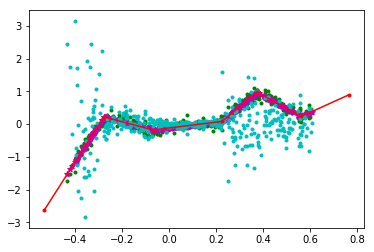

In [8]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')
# Y = spline.forward(x) + x
Y = spline.forward(x)
plt.scatter(x, Y, marker='*', color='m')
plt.scatter(x, dx, marker='.', color='c')

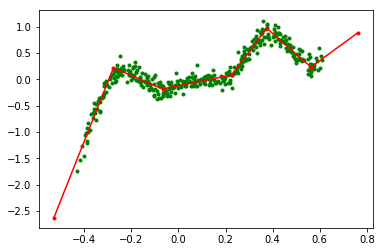

In [9]:
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')

In [10]:
def reverse0(self:tsp.Spline1D, y):
    x = np.zeros_like(self.input)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x += xpossible*self.rangeX[i]
    return x

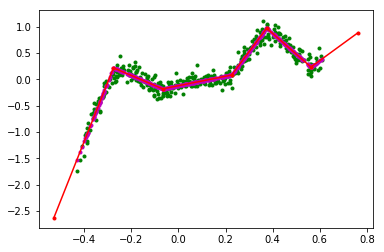

In [11]:
X = reverse0(spline, Y)
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')
plt.scatter(X,Y, marker='.', color='m')

## Reversing the actual target value of y

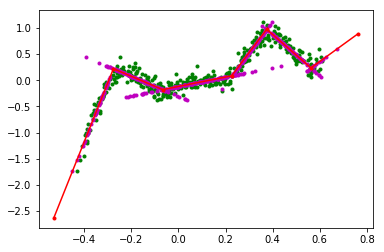

In [12]:
X = reverse0(spline, y)
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')
plt.scatter(X,y, marker='.', color='m')

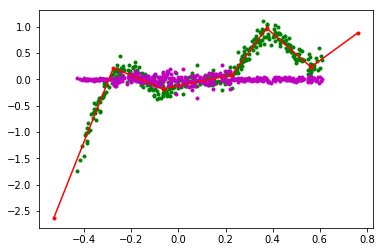

In [13]:
dX = x - X
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')
plt.scatter(x,dX, marker='.', color='m')

## Reversing without prior knowledge of distribution

In [14]:
def _calculate_rangeY_(self:tsp.Spline1D, y):
    rangeY = np.zeros((self.n_points-1, y.shape[0]))
    def _inrange2_(X, break0, break1): #if x is after
        xmsk1 = X >= break0
        xmsk2 = X < break1
        xmsk12 = np.bitwise_and(xmsk1, xmsk2)
        xmsk3 = X < break0
        xmsk4 = X >= break1
        xmsk34 = np.bitwise_and(xmsk3, xmsk4)
        xs = np.bitwise_or(xmsk12, xmsk34)
        return xs

    for i in range(self.n_points-1):
        if self.n_points-2 == 0:
            rangeY[i] = _inrange2_(y, -np.inf, np.inf)
        elif i==0:
            sign = -1 if self.Y[0]<self.Y[1] else 1
            rangeY[i] = _inrange2_(y, sign*np.inf, self.Y[1])
        elif i== self.n_points-2:
            sign = 1 if self.Y[i]<self.Y[i+1] else -1
            rangeY[i] = _inrange2_(y, self.Y[i], sign*np.inf)
        else:
            rangeY[i] = _inrange2_(y, self.Y[i], self.Y[i+1])
#         rangeY[i] = _inrange2_(y, self.Y[i], self.Y[i+1])
    notInRange = np.where(rangeY.sum(axis=0) == 0)[0]
#     print(notInRange)
#     print(rangeY.sum(axis=0))
#     print(self.rangeX.sum(axis=0)) 
#     print(self.rangeX[:, notInRange].sum(axis=0))     
#     print('_______-')
#     print(self.rangeX[:, notInRange])
#### for the values of y that are missed by the whole curve
    rangeY[:, notInRange] = self.rangeX[:, notInRange]
    return rangeY

In [15]:
rangeY = _calculate_rangeY_(spline, y)
rangeY, rangeY.shape

(array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]]), (6, 400))

In [17]:
rangeY.sum(axis=0) ## all points must have atleast one spline

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 3.,
       3., 1., 3., 3., 3., 1., 3., 1., 1., 3., 3., 1., 3., 3., 3., 3., 3.,
       3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 3., 1., 3., 3., 1., 3., 1., 3., 1., 1., 3., 3., 3.,
       3., 3., 3., 3., 3., 1., 3., 3., 1., 1., 1., 1., 1., 3., 3., 3., 3.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 3., 1., 1., 3., 3., 1., 1.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.

In [18]:
def reverse1(self:tsp.Spline1D, y, rangeY=None):
    if rangeY is None:
        rangeY = _calculate_rangeY_(self, y)
        
    x = np.zeros_like(self.rangeX)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x[i] = xpossible*rangeY[i]
    return x

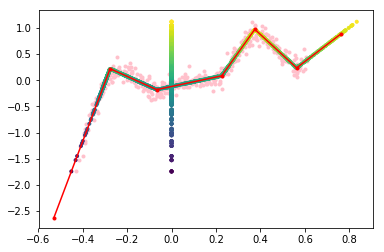

In [19]:
X = reverse1(spline, y)
plt.scatter(x, y, marker='.', color='pink')
plt.plot(spline.X, spline.Y, marker='.', color='r')
for Xi in X:
    plt.scatter(Xi,y, marker='.', c=y)

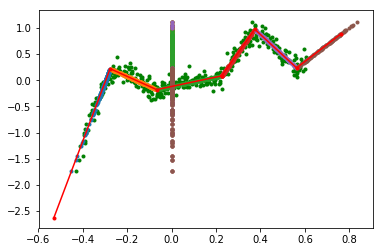

In [20]:
X = reverse1(spline, y)
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')
for Xi in X:
    plt.scatter(Xi,y, marker='.')

## Choosing the least error one

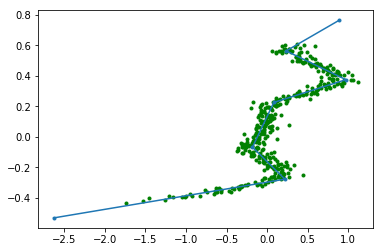

In [22]:
y_ = spline.forward(x)
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, marker='.')
# plt.scatter(y_, x, marker='.', color='c')

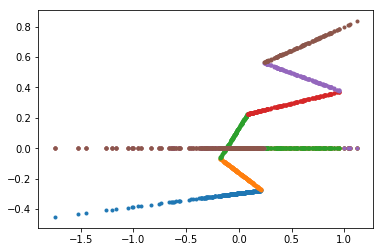

In [23]:
x_ = reverse1(spline, y)
for xi in x_:
    plt.scatter(y, xi, marker='.')

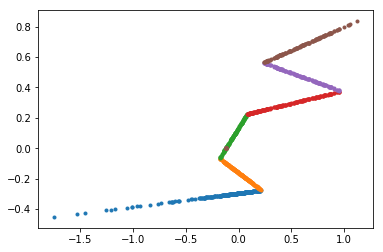

In [24]:
for xi in x_:
    y_ = spline.forward(xi)
    plt.scatter(y_, xi, marker='.')

In [33]:
rangeY[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [55]:
def reverse_min_error0(self:tsp.Spline1D, y, x, rangeY=None):
    if rangeY is None:
        rangeY = _calculate_rangeY_(self, y)
        
    x_ = np.zeros_like(y)
    min_error = np.ones_like(y)*99999
    
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        error = np.abs(xpossible- x)
        candidate = np.nonzero((error < min_error)*rangeY[i])
        min_error[candidate] = error[candidate]
        x_[candidate] = xpossible[candidate]
    return x_

In [56]:
x_rev = reverse_min_error0(spline, y, x)

In [75]:
def reverse_min_error1(self:tsp.Spline1D, y, x):
    x_ = reverse1(spline, y)
    y_list = []
    for xi in x_:
        y_ = self.forward(xi)
        y_list.append(y_)

    indx_of_min_error = np.empty_like(y, dtype=np.int64)
    min_error = np.ones_like(y)*99999
    for indx, y_ in enumerate(y_list):
        dy_ = np.abs(y_ - y)
        candidate = np.nonzero(dy_ < min_error)
        min_error[candidate] = dy_[candidate]
        indx_of_min_error[candidate] = indx
#     indx_of_min_error
    newx_ = np.empty_like(x)
    for indx, xi in enumerate(x_):
        mask = indx_of_min_error == indx
        newx_[mask] = xi[mask]
    return newx_

In [76]:
newx_ = reverse_min_error1(spline, y, x)

In [77]:
np.abs(newx_ - x_rev).mean() ## the methods dont produce same result

0.1121433143312915

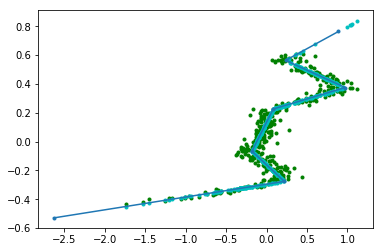

In [78]:
plt.scatter(y, x, marker='.', color='g')
plt.scatter(y, x_rev, marker='.', color='c')
plt.plot(spline.Y, spline.X, marker='.')

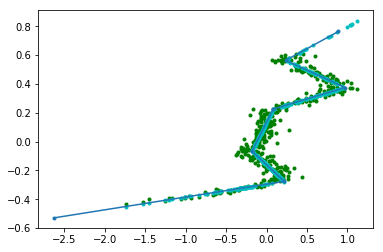

In [79]:
plt.scatter(y, x, marker='.', color='g')
plt.scatter(y, newx_, marker='.', color='c')
plt.plot(spline.Y, spline.X, marker='.')

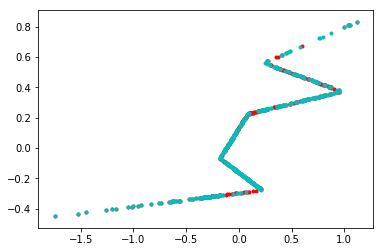

In [83]:
plt.scatter(y, x_rev, marker='.', color='r')
plt.scatter(y, newx_, marker='.', color='c')

In [84]:
np.abs(x - x_rev).mean()

0.06944531614591948

In [85]:
np.abs(x - newx_).mean()

0.16717072176762282

In [67]:
# x_rev seems better

## Sampling from possible multinoulli distribution

In [85]:
rangeY.shape

(7, 400)

In [88]:
def draw_sample_rangeY(rangeY):
    num_category = rangeY.shape[0]
    num_inputs = rangeY.shape[1]
    rangeY_sampled = np.zeros_like(rangeY)
    for i in range(num_inputs):
        elemRange = rangeY[:,i]
        non_zero_indx = np.nonzero(elemRange)[0]
        sample_nz_indx = np.random.randint(low=0, high=len(non_zero_indx))
        select_nz_indx = non_zero_indx[sample_nz_indx]
#         print(select_nz_indx, elemRange)
        rangeY_sampled[select_nz_indx,i] = 1.
    return rangeY_sampled

In [89]:
rangeY_sampled = draw_sample_rangeY(rangeY)
rangeY_sampled.shape, rangeY.shape

((7, 400), (7, 400))

In [90]:
rangeY_sampled.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [91]:
def reverse2(self:tsp.Spline1D, y, rangeY=None):
    if rangeY is None:
        rangeY = _calculate_rangeY_(self, y)
    rangeY_sampled = draw_sample_rangeY(rangeY)
        
    x = np.zeros_like(y)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x += xpossible*rangeY_sampled[i]
    return x

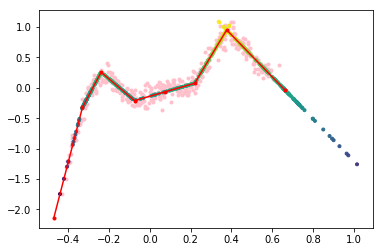

In [92]:
X = reverse2(spline, y)
plt.scatter(x, y, marker='.', color='pink')
plt.plot(spline.X, spline.Y, marker='.', color='r')
plt.scatter(X,y, marker='.', c=y)

In [93]:
np.array(y.tolist()*4).shape

(1600,)

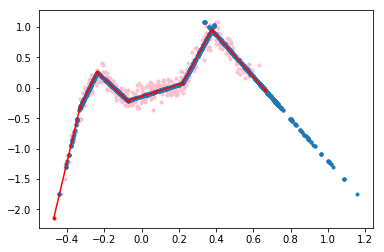

In [96]:
Y = np.array(y.tolist()*4)
_ = spline.forward(np.array(x.tolist()*4))
X = reverse2(spline, Y)
plt.scatter(x, y, marker='.', color='pink')
plt.plot(spline.X, spline.Y, marker='.', color='r')
plt.scatter(X,Y, marker='.')